
#  the model in this file comes from this website

#  https://geertlitjens.nl/post/getting-started-with-camelyon/



#  without editing the model, it is 80% accurate/confident

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Import NumPy to handle array's and Matplotlib for plotting loss curves
import numpy as np
import matplotlib.pyplot as plt

# Import TensorFlow and relevant Keras classes to setup the model
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.applications.densenet import DenseNet169, DenseNet201, DenseNet121
from tensorflow.keras.layers import Input, Flatten, Dense, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import losses, optimizers, activations, metrics

In [0]:
import tensorflow_datasets as tfds
#download=False - if you dont want to download data again
pcam, pcam_info = tfds.load("patch_camelyon", data_dir='/content/drive/My Drive/Colab Notebooks',download=False, with_info=True) 
#print(pcam_info)

In [12]:
densenet = DenseNet121(
    weights= 'imagenet',
    include_top=False,
    input_shape=(96,96,3)
)

#densenet.trainable = False

def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    
    sgd_opt = SGD(lr=0.001, momentum=0.9, decay=0.1, nesterov=True)
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=sgd_opt,#Adam(lr=0.0005,),
        metrics=['accuracy']
    )
    
    return model

model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 3, 3, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 7,039,554
Trainable params: 6,955,906
Non-trainable params: 83,648
_________________________________________________________________


In [0]:
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    #image = tf.image.rgb_to_grayscale(image)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

train_pipeline = pcam['train'].map(convert_sample,
                                   num_parallel_calls=8).shuffle(1024).repeat().batch(64).prefetch(2)
valid_pipeline = pcam['validation'].map(convert_sample,
                                        num_parallel_calls=8).repeat().batch(128).prefetch(2)

In [14]:
hist = model.fit(train_pipeline,
                 validation_data=valid_pipeline,
                 verbose=2, epochs=30, steps_per_epoch=4096, validation_steps=256)

Epoch 1/30
4096/4096 - 404s - loss: 0.4679 - accuracy: 0.8103 - val_loss: 0.3921 - val_accuracy: 0.8207
Epoch 2/30
4096/4096 - 403s - loss: 0.4225 - accuracy: 0.8270 - val_loss: 0.3873 - val_accuracy: 0.8228
Epoch 3/30
4096/4096 - 396s - loss: 0.4113 - accuracy: 0.8314 - val_loss: 0.3848 - val_accuracy: 0.8251
Epoch 4/30
4096/4096 - 397s - loss: 0.4062 - accuracy: 0.8319 - val_loss: 0.3830 - val_accuracy: 0.8255
Epoch 5/30
4096/4096 - 398s - loss: 0.3996 - accuracy: 0.8353 - val_loss: 0.3816 - val_accuracy: 0.8259
Epoch 6/30
4096/4096 - 396s - loss: 0.3962 - accuracy: 0.8369 - val_loss: 0.3812 - val_accuracy: 0.8264
Epoch 7/30
4096/4096 - 397s - loss: 0.3937 - accuracy: 0.8380 - val_loss: 0.3808 - val_accuracy: 0.8264
Epoch 8/30
4096/4096 - 395s - loss: 0.3921 - accuracy: 0.8383 - val_loss: 0.3796 - val_accuracy: 0.8267
Epoch 9/30
4096/4096 - 396s - loss: 0.3889 - accuracy: 0.8386 - val_loss: 0.3798 - val_accuracy: 0.8268
Epoch 10/30
4096/4096 - 398s - loss: 0.3874 - accuracy: 0.8403 -

In [15]:
test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=8).batch(128).prefetch(2)
print("Test set accuracy is {0:.4f}".format(model.evaluate(test_pipeline, steps=256, verbose=0)[1]))

Test set accuracy is 0.8153


In [0]:
#model.save("./saved_models/patchcamelyon.hf5")

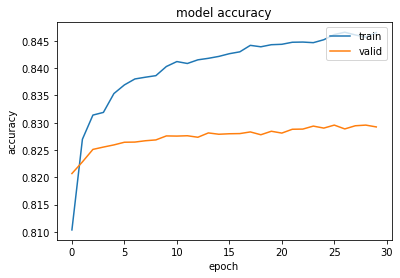

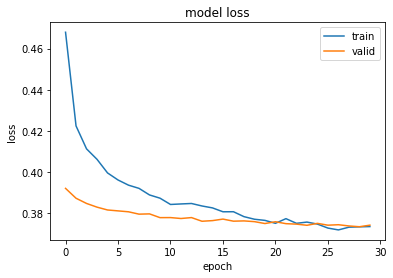

In [17]:
hist2=hist
plt.figure()
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

# summarize history for loss
plt.figure()
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [18]:
#Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras import optimizers
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
%matplotlib inline
sns.set_style("whitegrid")
np.random.seed(697)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [19]:
# Code below from https://www.kaggle.com/georsara1/95-auc-score-in-train-sample-with-neural-nets

#Predict on test set
predictions_NN_prob = model.predict(test_pipeline)
predictions_NN_prob = predictions_NN_prob[:,0]

predictions_NN_01 = np.where(predictions_NN_prob > 0.5, 0, 1) #Turn probability to 0-1 binary output

y_numpy = pcam['test'].as_numpy_iterator()
test_y = np.array([i['label'] for i in y_numpy])


acc_NN = accuracy_score(test_y, predictions_NN_01)
print('Overall accuracy of Neural Network model:', acc_NN)

Overall accuracy of Neural Network model: 0.815277099609375


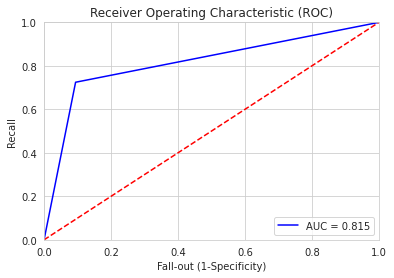

In [20]:

#Print Area Under Curve
false_positive_rate, recall, thresholds = roc_curve(test_y, predictions_NN_01)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

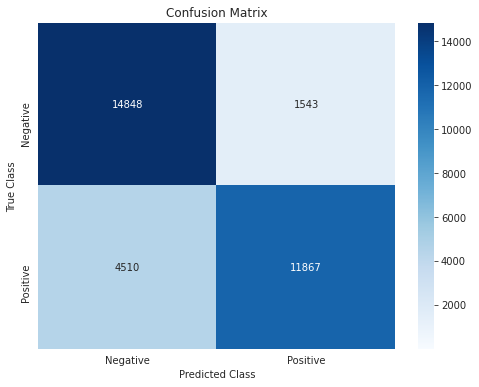

In [21]:
#Print Confusion Matrix
cm = confusion_matrix(test_y, predictions_NN_01)
labels = ['Negative', 'Positive']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()